In [2]:
import numpy as np
from datetime import datetime
import pandas as pd
import geopandas as gpd
from matplotlib import pyplot as plt
import xarray as xr
import contextily as ctx
import shapely
import pint_xarray
from metloom.pointdata import SnotelPointData, USGSPointData
import seaborn as sns

## To-Do List

- Restrict to 2011-2014
- Restrict to January-April
- Investigate the rolling mean function
- 

In [3]:
# include area plot 
# places where two snotels disagree 
# are there times when one site predicts snow and another predicts rain on snow at one time 
# see what temperature these things happen at 
# future work, make multiclass 
# visual of what rain on snow looks like, what characterizes it 
# plot: one axis has discharge, another has temp
# correlation matrix 
# january 1st through april 1st

In [4]:
pip install metloom

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install pint_xarray

Note: you may need to restart the kernel to use updated packages.


In [6]:
# we will look at january through april 
# predict discharge based on the snotel data
# spike in discharge means rain on snow, we will have 2 classes, so binary classification
# final goal: get a decision tree to predict discharge spikes based on snotel data 
# truth rain from snotel, infer it from discharge


# SWE: snow water equivalent: determines how much water the snowpack contains

### Prediction

#### Predict discharge based on the snotel data

In [7]:
# do some cleaning, we've got some null values 
# null values will be replaced with the mean of the row before and after it

def fill_null(df):
    df = df.copy() 
    df = df.reset_index()
    for col in df.columns:
        print("cleaning ", col)
        null_indices = df[df[col].isnull()].index
        for i in null_indices:
            before = df.loc[i-1, col] if i > 0 else np.nan
            after = df.loc[i+1, col] if i < len(df) - 1 else np.nan

            #Handle cases where either before or after is also NaN
            valid_values = [x for x in [before, after] if pd.notna(x)]
            if valid_values:
              df.loc[i, col] = np.mean(valid_values)
            #If both before and after are NaN, leave the NaN as is

    print(df)
    return df

## Start here with the backfilled data

In [8]:
snotel_hourly = xr.open_dataset('../../data/snotel/snotel_hourly_backfill_1980_2024.zarr')
usgs_hourly = xr.open_dataset('../../data/stream/usgs_instantaneous_backfill_1980_2024.zarr')
usgs_hourly

/opt/conda/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/opt/conda/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/opt/conda/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/opt/conda/lib/python3.11/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 spec

<xarray.Dataset> Size: 27MB
Dimensions:       (site: 2, date: 1134647)
Coordinates:
    elevation_ft  (site) float64 16B ...
    site_name     (site) object 16B ...
    lon           (site) float64 16B ...
  * site          (site) object 16B '12172000' '12175500'
    lat           (site) float64 16B ...
  * date          (date) datetime64[ns] 9MB 1989-10-01T07:15:00 ... 2024-01-0...
Data variables:
    DISCHARGE     (date, site) float64 18MB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [9]:
# only keep 2019-2024

snotel_month_filtered = snotel_hourly.sel(date=snotel_hourly.date.dt.month.isin([1,2,3])).sel(date=slice('2019-01-01', '2024-04-01'))
discharge_month_filtered = usgs_hourly.sel(date=usgs_hourly.date.dt.month.isin([1,2,3])).sel(date=slice('2019-01-01', '2024-04-01'))

In [10]:
discharge_month_filtered

<xarray.Dataset> Size: 1MB
Dimensions:       (site: 2, date: 59060)
Coordinates:
    elevation_ft  (site) float64 16B ...
    site_name     (site) object 16B ...
    lon           (site) float64 16B ...
  * site          (site) object 16B '12172000' '12175500'
    lat           (site) float64 16B ...
  * date          (date) datetime64[ns] 472kB 2019-01-01 ... 2024-01-02T07:45:00
Data variables:
    DISCHARGE     (date, site) float64 945kB ...
Attributes:
    Description:  Streamflow Data
    Date Range:   1980-2024
    Sites:        Thunder Creek, Beaver Creek
    Frequency:    15-Min

In [11]:
# line up usgs discharge with their correct sites 

discharge = []
discharge_by_site = discharge_month_filtered.DISCHARGE.values
dishcarge_thunder = discharge_by_site[:,0]
dishcarge_beaver = discharge_by_site[:,1]
for i in range(0,len(dishcarge_thunder)):
    discharge.append(dishcarge_thunder[i])
    discharge.append(dishcarge_beaver[i])

In [12]:
# add discharge to the SNOTEL data 
snotel_hourly_gdf = snotel_month_filtered.to_dataframe().reset_index()
snotel_hourly_numeric = snotel_hourly_gdf.copy()
snotel_hourly_numeric['DISCHARGE'] = discharge
snotel_hourly_numeric


,date,site,ACCUMULATED PRECIPITATION,site_name,SNOWDEPTH,elevation_ft,SWE,lat,AIR TEMP,lon,DISCHARGE
0,2019-01-01 00:00:00,817:WA:SNTL,31.2,Beaver Creek,50.0,4310.0,15.2,48.528,12.56,-120.990,247.0
1,2019-01-01 00:00:00,990:WA:SNTL,35.6,Thunder Basin,56.0,3630.0,16.2,48.879,22.28,-121.256,240.0
2,2019-01-01 00:05:00,817:WA:SNTL,31.2,Beaver Creek,49.0,4310.0,15.2,48.528,10.94,-120.990,249.0
3,2019-01-01 00:05:00,990:WA:SNTL,35.5,Thunder Basin,56.0,3630.0,16.2,48.879,21.38,-121.256,NaN
4,2019-01-01 00:10:00,817:WA:SNTL,31.2,Beaver Creek,49.0,4310.0,15.2,48.528,10.94,-120.990,249.0
...,...,...,...,...,...,...,...,...,...,...,...
118115,2024-01-02 07:15:00,990:WA:SNTL,NaN,Thunder Basin,NaN,3630.0,NaN,48.879,NaN,-121.256,210.0
118116,2024-01-02 07:30:00,817:WA:SNTL,NaN,Beaver Creek,NaN,4310.0,NaN,48.528,NaN,-120.990,220.0
118117,2024-01-02 07:30:00,990:WA:SNTL,NaN,Thunder Basin,NaN,3630.0,NaN,48.879,NaN,-121.256,208.0
118118,2024-01-02 07:45:00,817:WA:SNTL,NaN,Beaver Creek,NaN,4310.0,NaN,48.528,NaN,-120.990,220.0


In [67]:
#grouped_by_site = snotel_hourly_numeric.groupby('site_name')

grouped_by_site = snotel_hourly_numeric.sort_values(['site','date'],ascending=True).groupby('site')
grouped_by_site =grouped_by_site.apply(pd.DataFrame)
grouped_by_site

/tmp/ipykernel_670/3260400871.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_by_site =grouped_by_site.apply(pd.DataFrame)


date         site  \
site                                                  
817:WA:SNTL 0      2019-01-01 00:00:00  817:WA:SNTL   
            2      2019-01-01 00:05:00  817:WA:SNTL   
            4      2019-01-01 00:10:00  817:WA:SNTL   
            6      2019-01-01 00:15:00  817:WA:SNTL   
            8      2019-01-01 00:20:00  817:WA:SNTL   
...                                ...          ...   
990:WA:SNTL 118111 2024-01-02 06:45:00  990:WA:SNTL   
            118113 2024-01-02 07:00:00  990:WA:SNTL   
            118115 2024-01-02 07:15:00  990:WA:SNTL   
            118117 2024-01-02 07:30:00  990:WA:SNTL   
            118119 2024-01-02 07:45:00  990:WA:SNTL   

                    ACCUMULATED PRECIPITATION      site_name  SNOWDEPTH  \
site                                                                      
817:WA:SNTL 0                            31.2   Beaver Creek       50.0   
            2                            31.2   Beaver Creek       49.0   
            4                            31.2   Beaver Creek       49.0   
            6                            31.2   Beaver Creek       49.0   
            8                            31.2   Beaver Creek       49.0   
...                                       ...            ...        ...   
990:WA:SNTL 118111                        NaN  Thunder Basin        NaN   
            118113                        NaN  Thunder Basin        NaN   
            118115                        NaN  Thunder Basin        NaN   
            118117                        NaN  Thunder Basin        NaN   
            118119                        NaN  Thunder Basin        NaN   

                    elevation_ft   SWE     lat  AIR TEMP      lon  DISCHARGE  
site                                                                          
817:WA:SNTL 0             4310.0  15.2  48.528     12.56 -120.990      247.0  
            2             4310.0  15.2  48.528     10.94 -120.990      249.0  
            4             4310.0  15.2  48.528     10.94 -120.990      249.0  
            6             4310.0  15.2  48.528     10.94 -120.990      249.0  
            8             4310.0  15.2  48.528     10.94 -120.990      247.0  
...                          ...   ...     ...       ...      ...        ...  
990:WA:SNTL 118111        3630.0   NaN  48.879       NaN -121.256      208.0  
            118113        3630.0   NaN  48.879       NaN -121.256      210.0  
            118115        3630.0   NaN  48.879       NaN -121.256      210.0  
            118117        3630.0   NaN  48.879       NaN -121.256      208.0  
            118119        3630.0   NaN  48.879       NaN -121.256      208.0  

[118120 rows x 11 columns]

In [14]:
# only keep numeric data 

data_numeric = grouped_by_site.filter(items=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'])

In [15]:
data_numeric

ACCUMULATED PRECIPITATION   SWE  AIR TEMP  DISCHARGE
site                                                                    
817:WA:SNTL 0                            31.2  15.2     12.56      247.0
            2                            31.2  15.2     10.94      249.0
            4                            31.2  15.2     10.94      249.0
            6                            31.2  15.2     10.94      249.0
            8                            31.2  15.2     10.94      247.0
...                                       ...   ...       ...        ...
990:WA:SNTL 118111                        NaN   NaN       NaN      208.0
            118113                        NaN   NaN       NaN      210.0
            118115                        NaN   NaN       NaN      210.0
            118117                        NaN   NaN       NaN      208.0
            118119                        NaN   NaN       NaN      208.0

[118120 rows x 4 columns]

In [16]:
# handle null values in the data

hourly_cleaned = fill_null(data_numeric)

cleaning  site
cleaning  level_1
cleaning  ACCUMULATED PRECIPITATION
cleaning  SWE
cleaning  AIR TEMP
cleaning  DISCHARGE
               site  level_1  ACCUMULATED PRECIPITATION   SWE  AIR TEMP  \
0       817:WA:SNTL        0                       31.2  15.2     12.56   
1       817:WA:SNTL        2                       31.2  15.2     10.94   
2       817:WA:SNTL        4                       31.2  15.2     10.94   
3       817:WA:SNTL        6                       31.2  15.2     10.94   
4       817:WA:SNTL        8                       31.2  15.2     10.94   
...             ...      ...                        ...   ...       ...   
118115  990:WA:SNTL   118111                       24.1   6.3     30.20   
118116  990:WA:SNTL   118113                       24.1   6.3     30.20   
118117  990:WA:SNTL   118115                       24.1   6.3     30.20   
118118  990:WA:SNTL   118117                       24.1   6.3     30.20   
118119  990:WA:SNTL   118119                       24

In [17]:
# get rid of the level_1 column that was added 

hourly_cleaned = hourly_cleaned.drop("level_1", axis =1)

In [18]:
hourly_cleaned

,site,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE
0,817:WA:SNTL,31.2,15.2,12.56,247.0
1,817:WA:SNTL,31.2,15.2,10.94,249.0
2,817:WA:SNTL,31.2,15.2,10.94,249.0
3,817:WA:SNTL,31.2,15.2,10.94,249.0
4,817:WA:SNTL,31.2,15.2,10.94,247.0
...,...,...,...,...,...
118115,990:WA:SNTL,24.1,6.3,30.20,208.0
118116,990:WA:SNTL,24.1,6.3,30.20,210.0
118117,990:WA:SNTL,24.1,6.3,30.20,210.0
118118,990:WA:SNTL,24.1,6.3,30.20,208.0


In [ ]:
# Jesses code 

### Classification
#### Fit a model based on air temp, SWE, and snow_depth to predict discharge 

In [19]:
# set grounds truths

# Snow or Rain on Snow: binary classification
# 0: Snow 
# 1: Rain on Snow 

### We will start with a basic rolling mean classification....

In [20]:
def rolling_stats(data,var):
    # Calculate the rolling median and standard deviation
    rolling_median = data[var].rolling(window=24, center=True, min_periods=1).median()
    rolling_std = data[var].rolling(window=24, center=True, min_periods=1).std()

    return [rolling_median, rolling_std]

In [178]:
def assign_labels(data, var): #air_temp = False):
    mu = rolling_stats(data,var)[0]
    sigma = rolling_stats(data,var)[1]

    truths = []
    mask = data[var] > mu+(sigma/2)
    truths = mask

    return truths

In [179]:
ground_truths = assign_labels(hourly_cleaned, 'DISCHARGE') #air_temp = False)

In [149]:
hourly_cleaned['ROS'] = ground_truths
hourly_cleaned['date'] = grouped_by_site['date'].values

events_by_site = hourly_cleaned.groupby('site').resample('D', on='date').max().drop(columns=['site']).dropna(how='any')

events_by_site.to_csv('../../data/classified_data/ros_events_by_site.csv')

## Correlation Matrix

<Axes: >

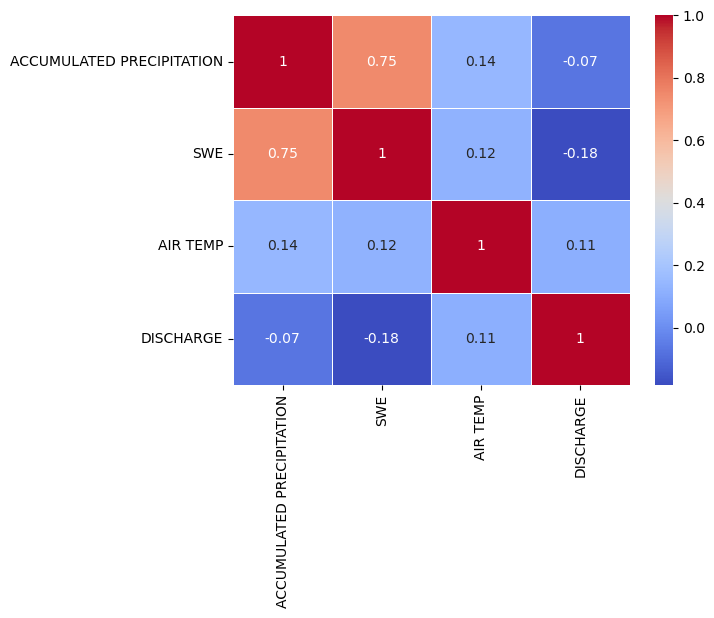

In [150]:
data_corr_matrix = hourly_cleaned.drop(['site', 'date', 'ROS'], axis=1).corr()
sns.heatmap(data_corr_matrix, annot=True, cmap='coolwarm', linewidths=.5)

## Relationship between air temp and discharge

Text(0, 0.5, 'Discharge (cubic feet/sec)')

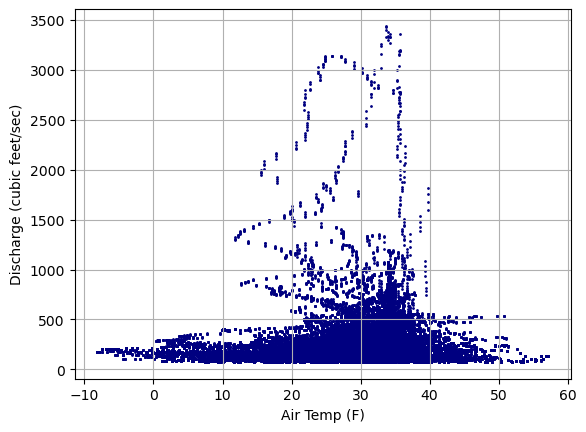

In [180]:
plt.grid()
plt.scatter(hourly_cleaned['AIR TEMP'], hourly_cleaned['DISCHARGE'], s=1, c='navy')
plt.xlabel("Air Temp (F)")
plt.ylabel("Discharge (cubic feet/sec)")

## Decision Tree Regression 
#### Predict float discharge values

In [181]:
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [182]:

X_data = hourly_cleaned.drop(['site', 'DISCHARGE', 'date', 'ROS'], axis =1)
X_data = X_data.to_numpy()

In [183]:
hourly_cleaned

,site,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE,ROS,date
0,817:WA:SNTL,31.2,15.2,12.56,247.0,False,2019-01-01 00:00:00
1,817:WA:SNTL,31.2,15.2,10.94,249.0,True,2019-01-01 00:05:00
2,817:WA:SNTL,31.2,15.2,10.94,249.0,True,2019-01-01 00:10:00
3,817:WA:SNTL,31.2,15.2,10.94,249.0,True,2019-01-01 00:15:00
4,817:WA:SNTL,31.2,15.2,10.94,247.0,False,2019-01-01 00:20:00
...,...,...,...,...,...,...,...
118115,990:WA:SNTL,24.1,6.3,30.20,208.0,False,2024-01-02 06:45:00
118116,990:WA:SNTL,24.1,6.3,30.20,210.0,False,2024-01-02 07:00:00
118117,990:WA:SNTL,24.1,6.3,30.20,210.0,False,2024-01-02 07:15:00
118118,990:WA:SNTL,24.1,6.3,30.20,208.0,False,2024-01-02 07:30:00


In [184]:
X_data

array([[31.2 , 15.2 , 12.56],
       [31.2 , 15.2 , 10.94],
       [31.2 , 15.2 , 10.94],
       ...,
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ]])

In [185]:
def run_regr(X,y, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
    clfr = tree.DecisionTreeRegressor(max_depth = max_depth)
    clfr.fit(X_train, y_train)
    score = clfr.score(X_test, y_test)
    print(f"Test Score: {score:.4f}")
    y_pred = clfr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    return score 

In [186]:
accs = []
for i in range(1,21):
    accs.append(run_regr(X_data,hourly_cleaned['DISCHARGE'], i))

Test Score: 0.1088
Mean Squared Error: 29535.0426
Test Score: 0.1522
Mean Squared Error: 27516.0922
Test Score: 0.2153
Mean Squared Error: 26010.0312
Test Score: 0.2778
Mean Squared Error: 24916.6504
Test Score: 0.4001
Mean Squared Error: 20134.5146
Test Score: 0.6675
Mean Squared Error: 11435.4427
Test Score: 0.7712
Mean Squared Error: 7977.1304
Test Score: 0.8639
Mean Squared Error: 4583.9339
Test Score: 0.9060
Mean Squared Error: 2825.8152
Test Score: 0.9263
Mean Squared Error: 2588.7707
Test Score: 0.9422
Mean Squared Error: 1959.6319
Test Score: 0.9647
Mean Squared Error: 1241.4522
Test Score: 0.9779
Mean Squared Error: 725.5196
Test Score: 0.9858
Mean Squared Error: 435.3367
Test Score: 0.9851
Mean Squared Error: 531.5070
Test Score: 0.9909
Mean Squared Error: 289.7933
Test Score: 0.9936
Mean Squared Error: 197.8318
Test Score: 0.9958
Mean Squared Error: 139.2354
Test Score: 0.9949
Mean Squared Error: 170.1998
Test Score: 0.9955
Mean Squared Error: 162.0036


Text(0, 0.5, 'Test Accuracy')

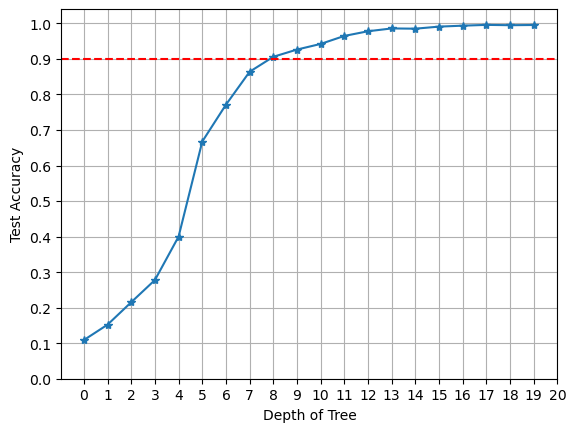

In [187]:
plt.plot(accs, '-*')
plt.grid()
custom_ticks = [i for i in range(0,21)]
custom_y = [0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]
plt.xticks(custom_ticks)
plt.yticks(custom_y)
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")

In [188]:
from sklearn import tree
from sklearn.model_selection import train_test_split

X = X_data
y = hourly_cleaned['DISCHARGE']

# i'll do 80/20 split
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
clfr = tree.DecisionTreeRegressor(max_depth = 10)
clfr.fit(X_train, y_train)
clfr.score(X_test, y_test)

0.9373113477443276

In [189]:
y_pred = clfr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.4f}")

Mean Squared Error: 2076.4376


In [190]:
clfr.get_depth()

10

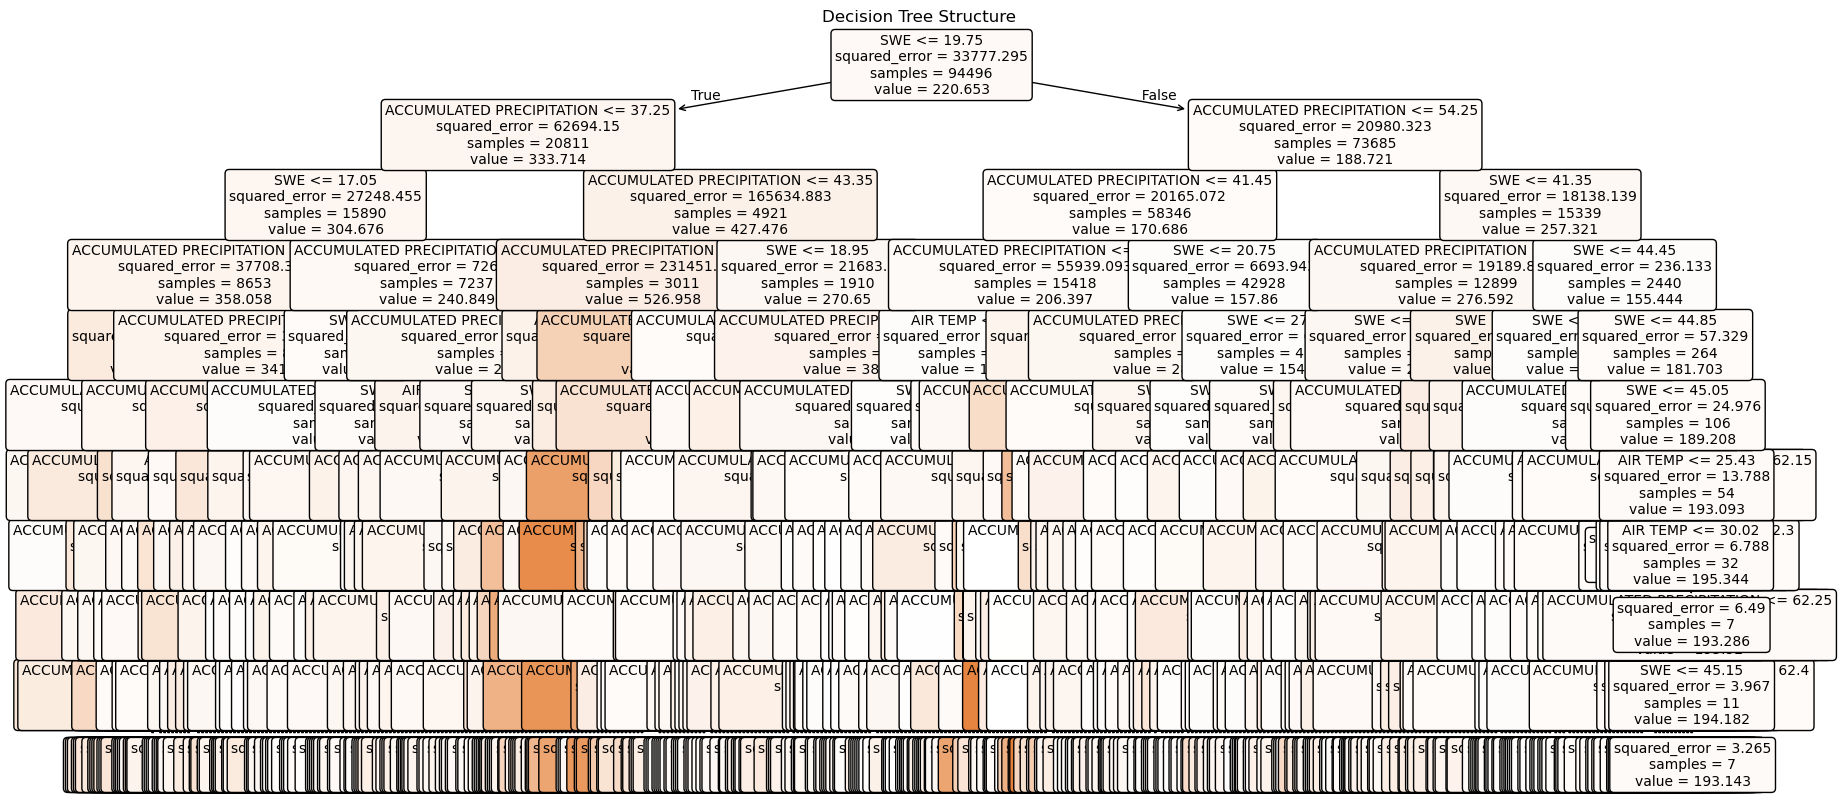

In [191]:
from sklearn.tree import plot_tree

# Visualizing decision tree
plt.figure(figsize=(20, 10))
plot_tree(
    clfr,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP'],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Structure")
plt.show()


In [192]:
y_1 = clfr.predict(X_test)

In [193]:
y_predicted = clfr.predict(X)

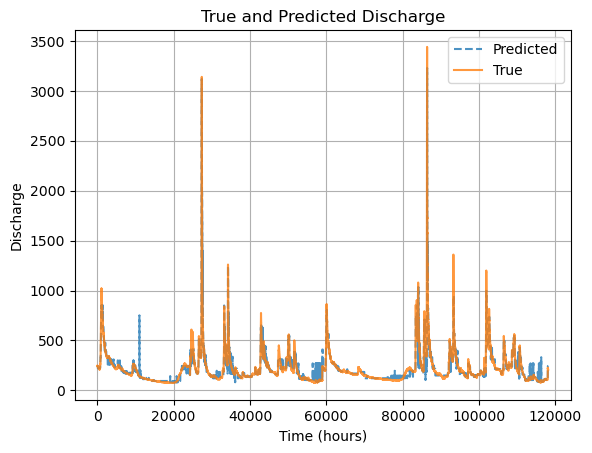

In [194]:
plt.title("True and Predicted Discharge")
#plt.plot(y_pred)
plt.plot(y_predicted, '--',label = 'Predicted', alpha = 0.8)
plt.plot(y, label = 'True', alpha = 0.8)
plt.legend()
plt.ylabel("Discharge")
plt.xlabel("Time (hours)")
plt.grid()

## Want to visualize the data with the regression line here 



In [195]:
len(hourly_cleaned['ACCUMULATED PRECIPITATION'])

118120

In [196]:
hourly_cleaned['ACCUMULATED PRECIPITATION']

0         31.2
1         31.2
2         31.2
3         31.2
4         31.2
          ... 
118115    24.1
118116    24.1
118117    24.1
118118    24.1
118119    24.1
Name: ACCUMULATED PRECIPITATION, Length: 118120, dtype: float64

In [197]:
len(X_test[:,0])

23624

## Decision Tree Classification

#### Predicts integer values 0 (snow)or 1 (rain on snow)

In [198]:
hourly_cleaned

,site,ACCUMULATED PRECIPITATION,SWE,AIR TEMP,DISCHARGE,ROS,date
0,817:WA:SNTL,31.2,15.2,12.56,247.0,False,2019-01-01 00:00:00
1,817:WA:SNTL,31.2,15.2,10.94,249.0,True,2019-01-01 00:05:00
2,817:WA:SNTL,31.2,15.2,10.94,249.0,True,2019-01-01 00:10:00
3,817:WA:SNTL,31.2,15.2,10.94,249.0,True,2019-01-01 00:15:00
4,817:WA:SNTL,31.2,15.2,10.94,247.0,False,2019-01-01 00:20:00
...,...,...,...,...,...,...,...
118115,990:WA:SNTL,24.1,6.3,30.20,208.0,False,2024-01-02 06:45:00
118116,990:WA:SNTL,24.1,6.3,30.20,210.0,False,2024-01-02 07:00:00
118117,990:WA:SNTL,24.1,6.3,30.20,210.0,False,2024-01-02 07:15:00
118118,990:WA:SNTL,24.1,6.3,30.20,208.0,False,2024-01-02 07:30:00


In [199]:
X_data_class

array([[31.2 , 15.2 , 12.56],
       [31.2 , 15.2 , 10.94],
       [31.2 , 15.2 , 10.94],
       ...,
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ],
       [24.1 ,  6.3 , 30.2 ]])

In [216]:
# will use sklearn's decision tree for now....

from sklearn import tree
X_data_class = hourly_cleaned.drop(["site", 'date', 'ROS', 'DISCHARGE'], axis =1).to_numpy()


X_train, X_test, y_train, y_test = train_test_split(
    X_data_class, ground_truths.to_numpy().tolist(), test_size=0.20)

clf = tree.DecisionTreeClassifier(max_depth = 8)

# y_train_labels will be a vector of 0s and 1s from the ground_truths 
clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=8)

In [217]:
clf.score(X_test, y_test)

0.9120386048086692

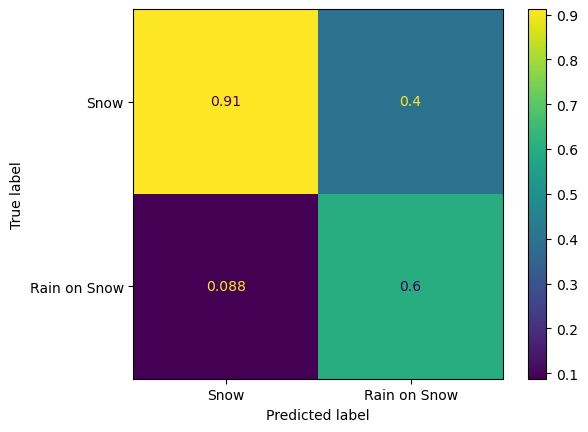

In [223]:
# add confusion matrix 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
y_true = y_test
y_pred = clf.predict(X_test)
cm = confusion_matrix(y_true, y_pred, normalize = 'pred')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ["Snow", "Rain on Snow"])
disp.plot()
plt.show()


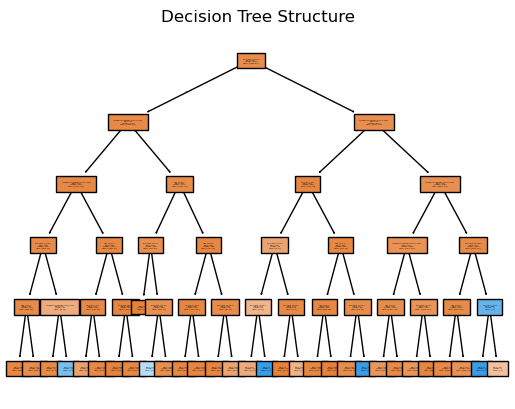

In [124]:
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=1
)
plt.title("Decision Tree Structure")
plt.show()

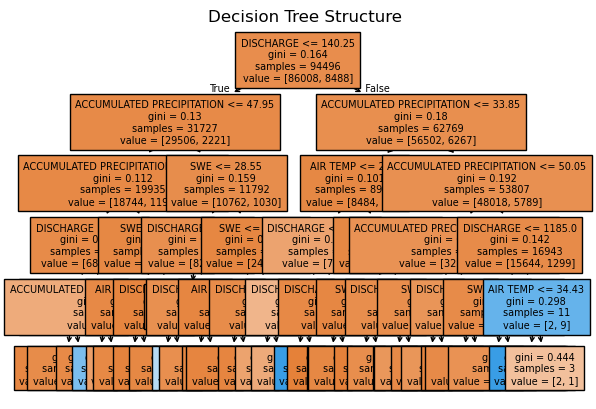

In [125]:
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=7
)
plt.title("Decision Tree Structure")
plt.show()

In [ ]:
plt.plot(accs, '-*')
plt.grid()
custom_ticks = [i for i in range(0,21)]
custom_y = [0,0.1,0.2,0.3,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1]
plt.xticks(custom_ticks)
plt.yticks(custom_y)
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")

## Tree Pruning

In [126]:
def run_class(X,y, max_depth):
    X_train, X_test, y_train, y_test = train_test_split(
    X_data, y, test_size=0.20)
 
    clf = tree.DecisionTreeClassifier(max_depth = max_depth)
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(f"Test Score: {score:.4f}")
    y_pred = clf.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    print(f"Mean Squared Error: {mse:.4f}")

    return score 

In [129]:
accs = []
for i in range(1,21):
    accs.append(run_class(X_data_class, ground_truths.to_numpy().tolist(), i))

Test Score: 0.9126
Mean Squared Error: 0.0874
Test Score: 0.9123
Mean Squared Error: 0.0877
Test Score: 0.9104
Mean Squared Error: 0.0896
Test Score: 0.9118
Mean Squared Error: 0.0882
Test Score: 0.9125
Mean Squared Error: 0.0875
Test Score: 0.9123
Mean Squared Error: 0.0877
Test Score: 0.9092
Mean Squared Error: 0.0908
Test Score: 0.9103
Mean Squared Error: 0.0897
Test Score: 0.9122
Mean Squared Error: 0.0878
Test Score: 0.9138
Mean Squared Error: 0.0862
Test Score: 0.9112
Mean Squared Error: 0.0888
Test Score: 0.9109
Mean Squared Error: 0.0891
Test Score: 0.9111
Mean Squared Error: 0.0889
Test Score: 0.9067
Mean Squared Error: 0.0933
Test Score: 0.9073
Mean Squared Error: 0.0927
Test Score: 0.9070
Mean Squared Error: 0.0930
Test Score: 0.9062
Mean Squared Error: 0.0938
Test Score: 0.9068
Mean Squared Error: 0.0932
Test Score: 0.9070
Mean Squared Error: 0.0930
Test Score: 0.9042
Mean Squared Error: 0.0958


Text(0.5, 1.0, 'Example of possible overfitting')

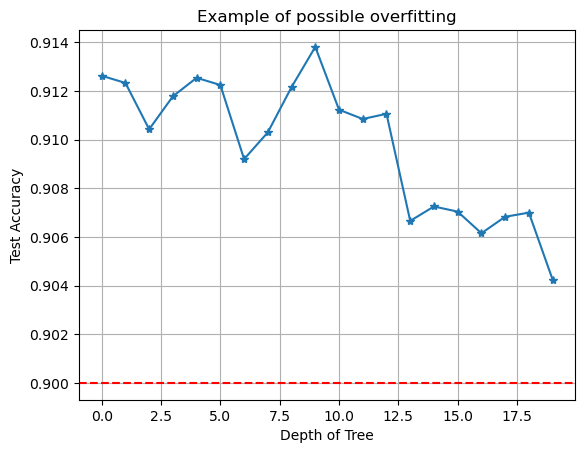

In [137]:
plt.plot(accs, '-*')
plt.grid()
plt.xlabel("Depth of Tree")
plt.axhline(0.9,linestyle = '--', c='red')
plt.ylabel("Test Accuracy")
plt.title("Example of possible overfitting")

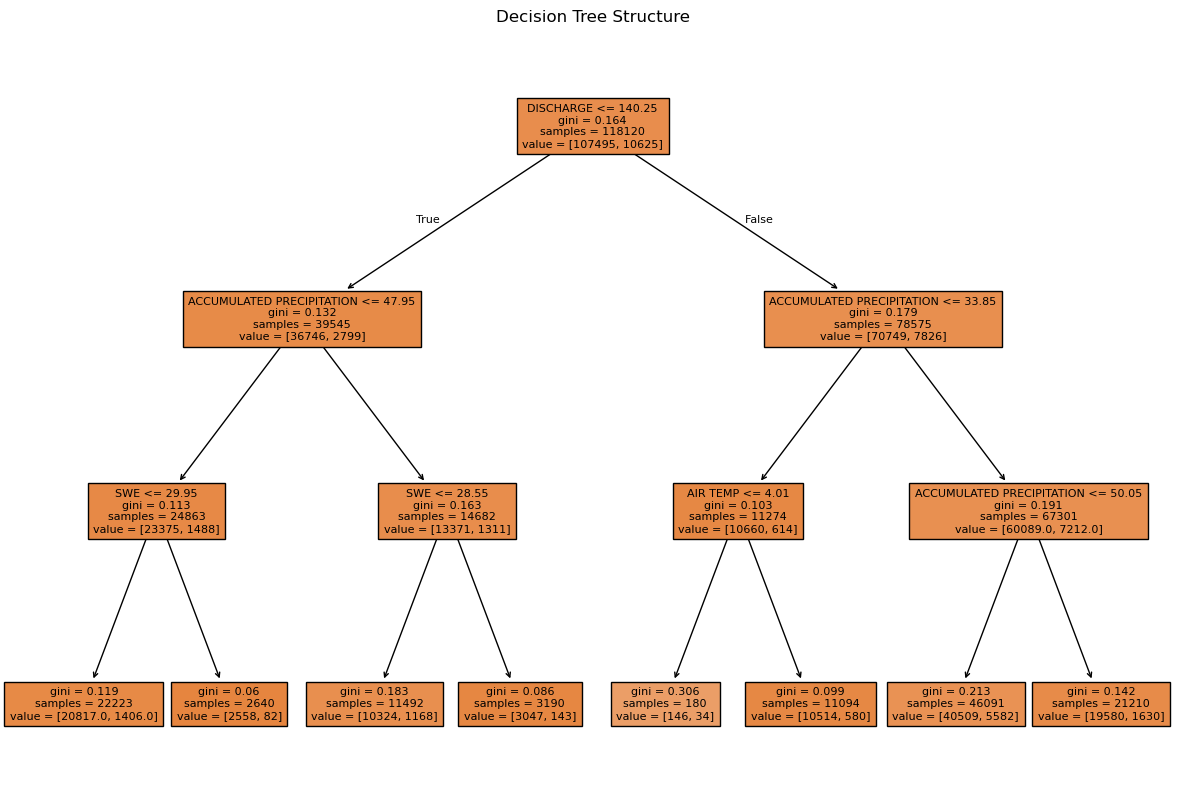

In [141]:
clf = tree.DecisionTreeClassifier(max_depth = 3)
clf.fit(X_data_class, ground_truths.to_numpy().tolist())
plt.figure(figsize=(15, 10))
plot_tree(
    clf,
    feature_names=['ACCUMULATED PRECIPITATION', 'SWE', 'AIR TEMP', 'DISCHARGE'],
    filled=True,
    #rounded=True,
    fontsize=8
)
plt.title("Decision Tree Structure")
plt.show()

### Do some more thorough pruning

In [ ]:
## TODO